# Assigment 3: Uncertainty predicition (classification task)

Dropout, a technique commonly used in neural networks to prevent overfitting, can also be applied to estimate the uncertainty of a model's predictions. Normally, dropout is only active during training, where it randomly deactivates neurons to improve generalization. However, by keeping dropout active during inference—a method known as Monte Carlo (MC) Dropout—it is possible to approximate the uncertainty associated with a model's predictions.

To estimate uncertainty using MC Dropout, the model performs multiple stochastic forward passes on the same input during inference. Each pass simulates a different "thinned" version of the network, as neurons are randomly deactivated according to the dropout probabilities. For a classification task, this results in a collection of probability distributions over the output classes, one from each forward pass.

This code implements a convolutional neural network (CNN) to classify the MNIST dataset (handwritten digit images). It includes a function to generate predictions with uncertainty by sampling the model's outputs multiple times.

+ `training=True` indicates that the model should run in "training mode", enabling behaviors specific to training, such as applying dropout layers



In [2]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# Load the MNIST dataset
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()

# Preprocess the data
x_train = x_train.astype("float32") / 255.0
x_test = x_test.astype("float32") / 255.0
x_train = np.expand_dims(x_train, -1)
x_test = np.expand_dims(x_test, -1)
num_classes = 10
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

def get_model():
    model = keras.Sequential(
        [
            layers.Conv2D(32, (3, 3), activation="relu", input_shape=(28, 28, 1)),
            layers.MaxPooling2D((2, 2)),
            layers.Dropout(0.25),  # Add dropout after max pooling
            layers.Conv2D(64, (3, 3), activation="relu"),
            layers.MaxPooling2D((2, 2)),
            layers.Dropout(0.25),  # Add dropout after max pooling
            layers.Flatten(),
            layers.Dense(128, activation="relu"),  # Add a dense layer before the output
            layers.Dropout(0.5),  # Add dropout before the final output layer
            layers.Dense(num_classes, activation="softmax"),
        ]
    )
    return model

# Create the model
model = get_model()

# Compile the model
model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

# Train the model
model.fit(x_train, y_train, batch_size=128, epochs=10, validation_split=0.1)

Epoch 1/10
422/422 [==============================] - 25s 56ms/step - loss: 0.3901 - accuracy: 0.8780 - val_loss: 0.0746 - val_accuracy: 0.9795
Epoch 2/10
422/422 [==============================] - 25s 59ms/step - loss: 0.1331 - accuracy: 0.9603 - val_loss: 0.0473 - val_accuracy: 0.9870
Epoch 3/10
422/422 [==============================] - 26s 63ms/step - loss: 0.0990 - accuracy: 0.9698 - val_loss: 0.0435 - val_accuracy: 0.9878
Epoch 4/10
422/422 [==============================] - 27s 64ms/step - loss: 0.0835 - accuracy: 0.9751 - val_loss: 0.0378 - val_accuracy: 0.9897
Epoch 5/10
422/422 [==============================] - 26s 62ms/step - loss: 0.0708 - accuracy: 0.9783 - val_loss: 0.0371 - val_accuracy: 0.9890
Epoch 6/10
422/422 [==============================] - 26s 62ms/step - loss: 0.0645 - accuracy: 0.9806 - val_loss: 0.0355 - val_accuracy: 0.9903
Epoch 7/10
422/422 [==============================] - 26s 62ms/step - loss: 0.0596 - accuracy: 0.9821 - val_loss: 0.0344 - val_accuracy:

mean_prediction [[9.14603220e-07 6.59119451e-06 1.18403705e-05 1.66237471e-04
  1.95054440e-07 3.98668647e-07 2.15461760e-09 9.99719322e-01
  6.64274239e-07 9.40417376e-05]]
std_prediction [[7.0752212e-06 4.1972995e-05 6.0242892e-05 1.4483621e-03 1.6211644e-06
  2.6496900e-06 1.5216047e-08 1.6302300e-03 5.5721466e-06 5.5205676e-04]]


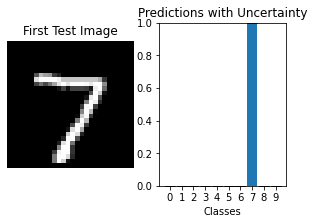

In [3]:
# function to generate predictions with uncertainty by sampling the model's outputs multiple times.
def predict_with_uncertainty(model, x, num_samples=100):
  predictions = []
  for _ in range(num_samples):
    predictions.append(model(x, training=True))
  predictions = np.array(predictions)
  mean_prediction = np.mean(predictions, axis=0)
  std_prediction = np.std(predictions, axis=0)
  return mean_prediction, std_prediction

# Make multiple predictions for the first test element
first_test_image = x_test[0:1]
mean_prediction, std_prediction = predict_with_uncertainty(model, first_test_image, num_samples=100)

print("mean_prediction",mean_prediction)
print("std_prediction",std_prediction)
# Plot the first test image
plt.figure(figsize=(5, 3))
plt.subplot(1, 2, 1)
plt.imshow(x_test[0].squeeze(), cmap='gray')
plt.title("First Test Image")
plt.axis("off")

# Plot predictions with uncertainty
plt.subplot(1, 2, 2)
plt.bar(range(num_classes), mean_prediction[0], yerr=std_prediction[0], capsize=5) #Error bars
plt.xlabel("Classes")
plt.title("Predictions with Uncertainty")
plt.xticks(range(num_classes))
plt.ylim(0,1)
plt.show()

In [4]:
# Evaluate the model on the test set using the predict_with_uncertainty function
mean_test_predictions, std_test_predictions = predict_with_uncertainty(model, x_test, num_samples=10)

# Calculate the accuracy
predicted_labels = np.argmax(mean_test_predictions, axis=1)
true_labels = np.argmax(y_test, axis=1)
accuracy = np.mean(predicted_labels == true_labels)

# Extract the uncertainty of the predicted class
uncertainty_of_predicted_class = std_test_predictions[np.arange(len(predicted_labels)), predicted_labels]

# Calculate the mean uncertainty of the predicted classes
mean_uncertainty_of_predicted_class = np.mean(uncertainty_of_predicted_class)

print(f"Test Accuracy: {accuracy}")
print(f"Mean Uncertainty of Predicted Class: {mean_uncertainty_of_predicted_class}")

Test Accuracy: 0.9914
Mean Uncertainty of Predicted Class: 0.029505837708711624


In [5]:
# Generate a new test dataset by applying a random rotation to all test elements.

from scipy.ndimage import rotate

def random_rotation_scipy(image, max_angle=90):
    angle = np.random.uniform(-max_angle, max_angle)
    rotated_image = rotate(image, angle, reshape=False, mode='nearest')
    return rotated_image

# Assuming x_test is your test dataset
rotated_x_test = np.array([random_rotation_scipy(img.squeeze()) for img in x_test])
rotated_x_test = np.expand_dims(rotated_x_test, -1) #restore the channel dimension

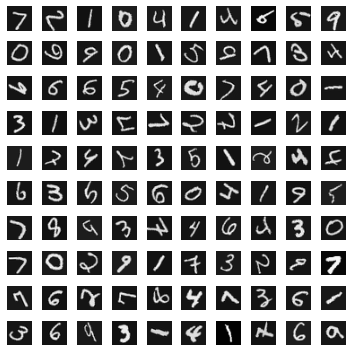

In [6]:

import matplotlib.pyplot as plt

# Reshape rotated_x_test to (10, 10, 28, 28) for the 10x10 matrix visualization
reshaped_images = rotated_x_test[:100].reshape(10, 10, 28, 28)

fig, axes = plt.subplots(10, 10, figsize=(5, 5))

for i in range(10):
    for j in range(10):
        axes[i, j].imshow(reshaped_images[i, j], cmap='gray')
        axes[i, j].axis('off')

plt.tight_layout()
plt.show()

In [7]:
# Now you can use rotated_x_test instead of x_test for further processing
mean_test_predictions, std_test_predictions= predict_with_uncertainty(model, rotated_x_test, num_samples=100)

# Calculate the accuracy
predicted_labels = np.argmax(mean_test_predictions, axis=1)
true_labels = np.argmax(y_test, axis=1)
accuracy = np.mean(predicted_labels == true_labels)

# Extract the uncertainty of the predicted class
uncertainty_of_predicted_class = std_test_predictions[np.arange(len(predicted_labels)), predicted_labels]

# Calculate the mean uncertainty of the predicted classes
mean_uncertainty_of_predicted_class = np.mean(uncertainty_of_predicted_class)

print(f"Test Accuracy: {accuracy}")
print(f"Mean Uncertainty of Predicted Class: {mean_uncertainty_of_predicted_class}")

Test Accuracy: 0.5773
Mean Uncertainty of Predicted Class: 0.1950901448726654


In [8]:
print(predicted_labels[4])
print(true_labels[4])
print(mean_test_predictions[4])
print(std_test_predictions[4])

4
4
[6.9611728e-05 2.2349559e-04 1.0105047e-04 4.6400362e-07 9.9693292e-01
 2.4732297e-05 1.7612166e-04 1.3354285e-05 5.1170609e-06 2.4531435e-03]
[3.0809996e-04 1.9079462e-03 4.5585673e-04 2.0605862e-06 1.6814506e-02
 1.9676813e-04 1.2982351e-03 8.1615151e-05 2.3662904e-05 1.6665701e-02]


## Exercise 1

+ **Develop and train** a linear model (not a neural network) to classify images as either "correctly classified" or "incorrectly classified" using prediction uncertainty as the key feature. High-confidence predictions should be generally associated with images that align more closely with the training distribution (e.g., non-rotated images). **Evaluate and report** the accuracy of this classifier.

+  To analyze the results, **visualize** the prediction confidence distribution (measured as the standard deviation of the softmax probabilities for the predicted class) using two overlapping histograms:
    + One histogram for correctly classified images.
    + One histogram for incorrectly classified images.

    X-axis label: "Standard Deviation of Softmax Probabilities (Prediction Confidence)"

    Y-axis label: "Number of Images" or "Frequency"

    Insight: Clear clustering of correctly classified vs. incorrectly classified images indicates that the classifier successfully learns to differentiate the two based on prediction confidence.


Accuracy of the linear model: 0.79


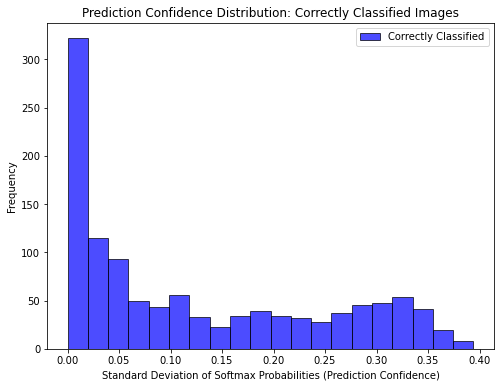

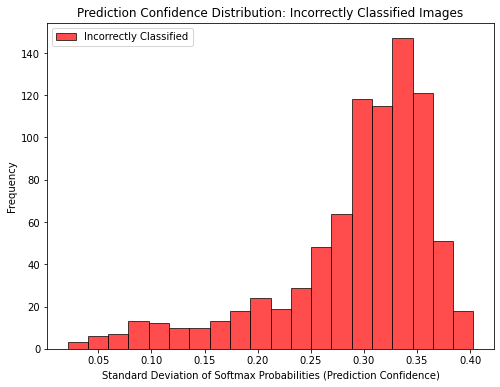

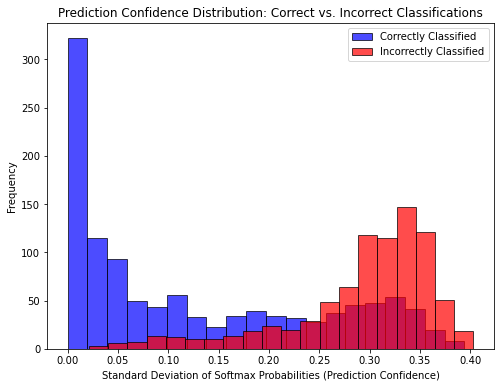

In [11]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

# Generate labels for correct/incorrect classification
mean_test_predictions, std_test_predictions = predict_with_uncertainty(
    model, rotated_x_test, num_samples=100
)
predicted_labels = np.argmax(mean_test_predictions, axis=1)
true_labels = np.argmax(y_test, axis=1)

# Correctly classified = 1, Incorrectly classified = 0
correctly_classified = (predicted_labels == true_labels).astype(int)

# Prepare the data for the linear model
uncertainty_feature = std_test_predictions[np.arange(len(predicted_labels)), predicted_labels]

# Train-test split for proper evaluation
X_train, X_test, y_train, y_test_split = train_test_split(
    uncertainty_feature.reshape(-1, 1),  # Reshape to 2D for sklearn
    correctly_classified,
    test_size=0.2,  # 20% for testing
    random_state=42
)

# Train a linear model
linear_model = LogisticRegression()
linear_model.fit(X_train, y_train)

# Evaluate the model on the test set
y_pred = linear_model.predict(X_test)
accuracy = accuracy_score(y_test_split, y_pred)
print(f"Accuracy of the linear model: {accuracy:.2f}")

# Separate uncertainty values for correctly and incorrectly classified images
correct_uncertainty = X_test[y_test_split == 1].flatten()
incorrect_uncertainty = X_test[y_test_split == 0].flatten()

# Plot for correctly classified images
plt.figure(figsize=(8, 6))
plt.hist(
    correct_uncertainty,
    bins=20,
    alpha=0.7,
    label="Correctly Classified",
    color="blue",
    edgecolor="black",
)
plt.xlabel("Standard Deviation of Softmax Probabilities (Prediction Confidence)")
plt.ylabel("Frequency")
plt.title("Prediction Confidence Distribution: Correctly Classified Images")
plt.legend()
plt.show()

# Plot for incorrectly classified images
plt.figure(figsize=(8, 6))
plt.hist(
    incorrect_uncertainty,
    bins=20,
    alpha=0.7,
    label="Incorrectly Classified",
    color="red",
    edgecolor="black",
)
plt.xlabel("Standard Deviation of Softmax Probabilities (Prediction Confidence)")
plt.ylabel("Frequency")
plt.title("Prediction Confidence Distribution: Incorrectly Classified Images")
plt.legend()
plt.show()

# Overlapping histogram for comparison
plt.figure(figsize=(8, 6))
plt.hist(
    correct_uncertainty,
    bins=20,
    alpha=0.7,
    label="Correctly Classified",
    color="blue",
    edgecolor="black",
)
plt.hist(
    incorrect_uncertainty,
    bins=20,
    alpha=0.7,
    label="Incorrectly Classified",
    color="red",
    edgecolor="black",
)
plt.xlabel("Standard Deviation of Softmax Probabilities (Prediction Confidence)")
plt.ylabel("Frequency")
plt.title("Prediction Confidence Distribution: Correct vs. Incorrect Classifications")
plt.legend()
plt.show()







## Exercise 2

If you want to use a measure other than the standard deviation (std) to quantify uncertainty, there are several alternative approaches. Each captures uncertainty from a different perspective, which might be more suitable depending on your application. Below are some options:

+ **Entropy** measures the "spread" of the predicted probability distribution. High entropy indicates a flat distribution (greater uncertainty), while low entropy indicates a sharp distribution (high confidence).
+ The **variation ratio** measures the proportion of stochastic forward passes where the model's most confident class does not match the mode class.
+ The **difference between the maximum and minimum predicted probabilities** across Monte Carlo passes for the predicted class.
+ **Least confidence**: the difference between the probability of the predicted class and 100% probability.
+ **Margin of confidence**: the difference between the probability of the top two most confident predictions.

Can you think of a better strategy to use uncertainty to classify images as either "correctly classified" or "incorrectly classified" based on this measures? Report the accuracy of the best classifier you can develop.


In [10]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import entropy
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.utils import resample
from sklearn.metrics import accuracy_score
from scipy.ndimage import rotate

# Function to apply random rotations
def random_rotation_scipy(image, max_angle=90):
    """
    Applies a random rotation to an image.
    Args:
    - image: Input image.
    - max_angle: Maximum rotation angle in degrees.
    Returns:
    - Rotated image.
    """
    angle = np.random.uniform(-max_angle, max_angle)
    rotated_image = rotate(image, angle, reshape=False, mode='nearest')
    return rotated_image

# Generate rotated test images
rotated_x_test = np.array([random_rotation_scipy(img.squeeze()) for img in x_test])
rotated_x_test = np.expand_dims(rotated_x_test, -1)  # Restore channel dimension

# Functions to compute alternative uncertainty measures
def compute_entropy(mean_predictions):
    return np.array([entropy(pred) for pred in mean_predictions])

def compute_variation_ratio(predictions):
    mc_classes = np.argmax(predictions, axis=2)  # (num_MC_samples, num_samples)
    mode_class = np.apply_along_axis(lambda x: np.bincount(x).argmax(), axis=0, arr=mc_classes)
    mode_frequency = np.array([(mc_classes[:, i] == mode_class[i]).sum() for i in range(mc_classes.shape[1])])
    return 1 - (mode_frequency / mc_classes.shape[0])

def compute_max_min_diff(predictions):
    return predictions.max(axis=1) - predictions.min(axis=1)

def compute_least_confidence(mean_predictions):
    return 1 - np.max(mean_predictions, axis=1)

def compute_margin_of_confidence(mean_predictions):
    sorted_probs = np.sort(mean_predictions, axis=1)
    return sorted_probs[:, -1] - sorted_probs[:, -2]

# Generate predictions with uncertainty using the rotated test set
raw_predictions = np.array([model(rotated_x_test, training=True).numpy() for _ in range(100)])  # Shape: (100, num_samples, num_classes)
mean_test_predictions = raw_predictions.mean(axis=0)
std_test_predictions = raw_predictions.std(axis=0)

# Compute uncertainty measures
entropy_values = compute_entropy(mean_test_predictions)
variation_ratio_values = compute_variation_ratio(raw_predictions)
max_min_diff_values = compute_max_min_diff(raw_predictions.mean(axis=0))
least_confidence_values = compute_least_confidence(mean_test_predictions)
margin_of_confidence_values = compute_margin_of_confidence(mean_test_predictions)

# Create dictionary of all uncertainty measures
uncertainty_measures = {
    "Entropy": entropy_values,
    "Variation Ratio": variation_ratio_values,
    "Max-Min Difference": max_min_diff_values,
    "Least Confidence": least_confidence_values,
    "Margin of Confidence": margin_of_confidence_values,
}

# Ensure correctness labels are defined
predicted_labels = np.argmax(mean_test_predictions, axis=1)
true_labels = np.argmax(y_test, axis=1)
correctness_labels = (predicted_labels == true_labels).astype(int)

# Downsample the majority class to balance the dataset
correct_indices = np.where(correctness_labels == 1)[0]
incorrect_indices = np.where(correctness_labels == 0)[0]

min_class_size = min(len(correct_indices), len(incorrect_indices))
balanced_indices = np.concatenate([
    resample(correct_indices, n_samples=min_class_size, replace=False, random_state=42),
    resample(incorrect_indices, n_samples=min_class_size, replace=False, random_state=42)
])

np.random.shuffle(balanced_indices)
correctness_labels = correctness_labels[balanced_indices]

for measure_name in uncertainty_measures:
    uncertainty_measures[measure_name] = uncertainty_measures[measure_name][balanced_indices]

# Normalize uncertainty measures and add noise
scaler = MinMaxScaler()
for measure_name in uncertainty_measures:
    uncertainty_measures[measure_name] = scaler.fit_transform(
        uncertainty_measures[measure_name].reshape(-1, 1)
    ).flatten() + np.random.normal(0, 0.1, size=len(correctness_labels))  # Increased noise

# Number of samples for train-test split
train_size = int(len(correctness_labels) * 0.8)  # 80% for training

# Train classifiers for each uncertainty measure and evaluate accuracy using SVM
accuracies = {}
for measure_name, measure_values in uncertainty_measures.items():
    # Train-test split
    measure_train, measure_test = measure_values[:train_size], measure_values[train_size:]
    labels_train, labels_test = correctness_labels[:train_size], correctness_labels[train_size:]

    # Train a Support Vector Machine (SVM) classifier
    svm_classifier = SVC(kernel='rbf', C=1, gamma='auto')
    svm_classifier.fit(measure_train.reshape(-1, 1), labels_train)

    # Evaluate accuracy using cross-validation
    scores = cross_val_score(
        svm_classifier,
        measure_values.reshape(-1, 1),
        correctness_labels,
        cv=5
    )
    accuracies[measure_name] = np.mean(scores)
    print(f"{measure_name} Classifier Accuracy: {accuracies[measure_name]:.2f}")

# Identify the best strategy
best_measure = max(accuracies, key=accuracies.get)
print(f"Best Measure: {best_measure} with Accuracy: {accuracies[best_measure]:.2f}")




Entropy Classifier Accuracy: 0.78
Variation Ratio Classifier Accuracy: 0.76
Max-Min Difference Classifier Accuracy: 0.77
Least Confidence Classifier Accuracy: 0.77
Margin of Confidence Classifier Accuracy: 0.77
Best Measure: Entropy with Accuracy: 0.78


## Bonus Exercise (not mandatory)

Analyze the Impact of Different Rotation Angles on Model Accuracy

Currently, the code applies random rotations between -90 and +90 degrees to the MNIST test images.  Modify the code to systematically investigate how different rotation angles affect the model's accuracy.


1. **Parameterize the Rotation Angle:** Instead of random rotations, introduce a parameter `rotation_angle` to the `random_rotation_scipy` function or create a new rotation function. This parameter will control the degree of rotation applied to the images.

2. **Iterate Through Angles:** Create a loop that iterates through a range of rotation angles (e.g., from -90 to +90 degrees in 5-degree increments, or a smaller range for quicker testing).

3. **Calculate and Store Accuracy:** For each rotation angle:
    - Apply the rotation to the test images.
    - Calculate the model's accuracy on the rotated images, as done in the existing code.
    - Store the accuracy value in a list or dictionary associated with the corresponding rotation angle.

4. **Visualize Results:** Create a plot showing the accuracy as a function of the rotation angle. This plot will visually demonstrate the model's robustness to image rotations.  Use `matplotlib.pyplot`.

**Example of the plot:**
The x-axis would be the rotation angle. The y-axis would be the accuracy.


In [ ]:
# your code here